# Определитель автора почерка

## Модель
Была создана многослойная нейронная сеть в Keras для классификации (определения) автора почерка.

## Результаты
Точность работы алгоритма на тестовых данных : 94.1%

In [1]:
# Подключение нужных библиотек.
from __future__ import division
import numpy as np
import os
import glob
from PIL import Image
from random import *
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop

In [2]:
# Создание сопоставления для записи предложений.
# Создание словаря с отображением формы и записи.
d = {}
with open('forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer

In [3]:
# Создание списка имен файлов и соответствующих имен целевой записи.
tmp = []
target_list = []
path_to_files = os.path.join('data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
    print(filename)
    tmp.append(filename)
    image_name = filename.split('\\')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))
img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files)
print(img_targets)

data_subset\a01-000u-s00-00.png
data_subset\a01-000u-s00-01.png
data_subset\a01-000u-s00-02.png
data_subset\a01-000u-s00-03.png
data_subset\a01-000u-s01-00.png
['data_subset\\a01-000u-s00-00.png' 'data_subset\\a01-000u-s00-01.png'
 'data_subset\\a01-000u-s00-02.png' 'data_subset\\a01-000u-s00-03.png'
 'data_subset\\a01-000u-s01-00.png']
['000' '000' '000' '000' '000']


## Визуализация набора данных

Входные тестовые данные:

<img src="data_subset/a01-000u-s00-00.png"
     style="float: left; margin-right: 10px;" width = 800 />

    
<img src="data_subset/a01-000u-s00-01.png"
     style="float: left; margin-right: 10px;" width = 800 />

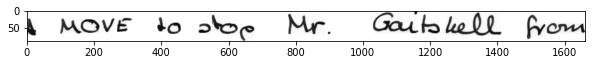

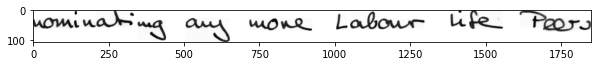

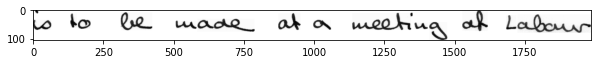

In [4]:
# Визуализация данных.
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

In [5]:
# Кодирование имен входных файлов авторов.
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:5], img_targets[:5], encoded_Y[:5])

['data_subset\\a01-000u-s00-00.png' 'data_subset\\a01-000u-s00-01.png'
 'data_subset\\a01-000u-s00-02.png' 'data_subset\\a01-000u-s00-03.png'
 'data_subset\\a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [6]:
# Разделение и валидация в соотношение 4:1:1.

from sklearn.model_selection import train_test_split
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3,) (1,) (1,)
(3,) (1,) (1,)


## Входные данные для модели

Входными данным являются не цельные тексты, а кусочки текстов.
Работа алгоритма:
* Изменение размера каждого предложения таким образом, чтобы новая высота составляла 113 пикселей, а новая ширина была такой, чтобы сохранялось исходное соотношение сторон.
* Как указано в документе, искажение формы изображения путем изменения соотношения сторон привело к значительному снижению производительности модели.
* На скорректированном изображении случайным образом обрезаются участки размером 113x113.

Пример обрезки участков:

<img src='combined.jpeg' width=200>


In [7]:
# Функция генератора для генерации случайных урожаев из каждого предложения.

# Случайная обрезка патчей на изображениях размером 113x113 из этих изображений.

batch_size = 16
num_classes = 50

# Геренация даты.
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1:  # Цикл бесконечен, чтобы генератор никогда не завершался
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Изменяем размер так, чтобы высота = 113, сохраняя соотношение сторон
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Создайте патчи размером 113x113 из этого измененного изображения и сохраняем случайные 10% патчей.

                avail_x_points = list(range(0, now_width - 113 ))# общее количество начальных точек x составляет от 0 до ширины -113

                
                pick_num = int(len(avail_x_points)*factor)

                
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # обрезание изображения.
            X_train = np.array(images)
            y_train = np.array(targets)

            # изменение формы X_train для последующей загрузки.
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            
            X_train = X_train.astype('float32')
            X_train /= 255

         
            y_train = to_categorical(y_train, num_classes)

            yield shuffle(X_train, y_train)

In [8]:
# Генерация данных для обучения и проверки.
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

In [9]:
# Построение нейронной сети в Keras.

# Функция для изменения размера изображения до 56x56.
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image,[56,56])

# Функция для изменения размера изображения до 64x64.
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Повторное использование данных в нейронной сети.
model.add(Lambda(resize_image))  # изменение размера изображений, чтобы упростить вычисления

# Модель неройнной сети и ее построение, предложенной в документе

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 115, 115, 1)      0         
 2D)                                                             
                                                                 
 lambda (Lambda)             (None, 56, 56, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        832       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                                        

In [10]:
# Обучение модели.

nb_epoch = 1

samples_per_epoch = 100
nb_val_samples = 100


# Сохранение каждой модели с помощью контрольной точки Keras.
from keras.callbacks import ModelCheckpoint
filepath="check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

# Генератор подгонки модели.
history_object = model.fit_generator(train_generator, steps_per_epoch=samples_per_epoch, epochs=nb_epoch, verbose=1, 
                                     callbacks=callbacks_list,
                                     validation_data=validation_generator,
                                     validation_steps=nb_val_samples)

C:\Users\Renar\AppData\Local\Temp\ipykernel_5044\303268253.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_object = model.fit_generator(train_generator, steps_per_epoch=samples_per_epoch, epochs=nb_epoch, verbose=1,
C:\Users\Renar\AppData\Local\Temp\ipykernel_5044\1214484299.py:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


100/100 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9902
Epoch 1: saving model to check-01-0.0000.hdf5
100/100 [==============================] - 131s 1s/step - loss: 0.0779 - accuracy: 0.9902 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


## Тестовая производительность модели на тестовом наборе

1. Тестовая работа алгоритма.
2. Входные данные, предположительно, принадлежат одному и тому же автору.

In [12]:
# Загрузка, сохранение модели и использование ее для прогнозирования на тестовом наборе.
model.load_weights('check-01-0.0000.hdf5')
scores = model.evaluate_generator(test_generator, 100) 
print(scores)
print("Accuracy = ", scores[1])

C:\Users\Renar\AppData\Local\Temp\ipykernel_5044\1935814408.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, 100)
C:\Users\Renar\AppData\Local\Temp\ipykernel_5044\1214484299.py:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


[0.0, 1.0]
Accuracy =  1.0


In [13]:
images = []
for filename in test_files[:50]:
    im = Image.open(filename)
    cur_width = im.size[0]
    cur_height = im.size[1]

    height_fac = 113 / cur_height

    new_width = int(cur_width * height_fac)
    size = new_width, 113

    imresize = im.resize((size), Image.ANTIALIAS)  # Изменяем размер изображения.
    now_width = imresize.size[0]
    now_height = imresize.size[1]
    # Создайте патчи размером 113x113 из этого измененного изображения и сохраняем случайные 10% патчей.

    avail_x_points = list(range(0, now_width - 113 ))# общее количество начальных точек x составляет от 0 до ширины -113

    factor = 0.1
    pick_num = int(len(avail_x_points)*factor)
    
    random_startx = sample(avail_x_points,  pick_num)

    for start in random_startx:
        imcrop = imresize.crop((start, 0, start+113, 113))
        images.append(np.asarray(imcrop))
        
    X_test = np.array(images)
    
    X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
    X_test = X_test.astype('float32')
    X_test /= 255
    shuffle(X_test)

print(X_test.shape)

(199, 113, 113, 1)


C:\Users\Renar\AppData\Local\Temp\ipykernel_5044\2765556598.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


In [19]:
# Работа с результатами из модели.
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
print(predicted_writer)

7/7 [==============================] - 0s 9ms/step
(199, 50)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


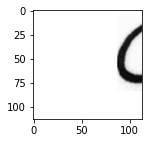

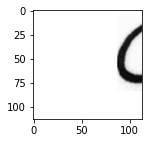

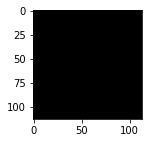

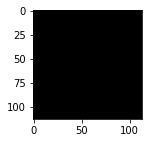

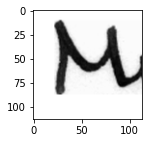

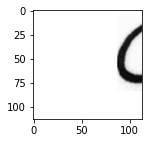

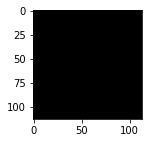

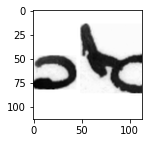

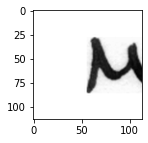

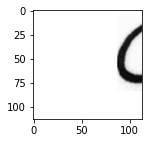

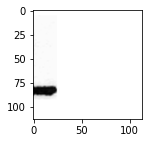

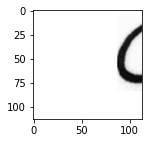

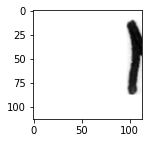

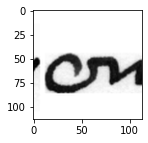

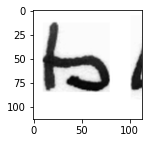

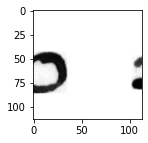

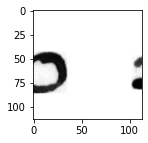

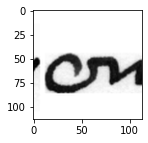

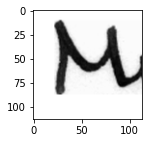

In [20]:
writer_number = 0
total_images =10
counter = 0
print(predicted_writer)
for i in range(len(predicted_writer)//10):
    if predicted_writer[i] == writer_number:
        image = X_test[i].squeeze()
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap ='gray')

## Пример работы алгоритма: